In [5]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit

# neural network packages
import torch
import torch.utils
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

# data processing from scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split

# to estimate the HAR model
from statsmodels.regression.linear_model import OLS
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.api as sm

# own helping code for estimation, data processing etc.
from utils.estimating import EarlyStopper, model_estimator, kfolds_fit_and_evaluate_model, single_fit_and_evaluate_model, fit_and_evaluateHAR
from utils.preprocessing import DataSet, DataSetNump, pre_process_all_data
from utils.functions import get_rv_from_yahoo, get_rv_from_data, get_tickers_in_data, print_nicely, reset_model_weights
from utils.modelbuilder import ForwardNeuralNetwork

# diebold mariano to compare 2 predictions
from dieboldmariano import dm_test

# ignore annoying warnings
import warnings
warnings.simplefilter("ignore")

### Process Data to Features, Targets and Divide in Training/Validation Data
- First the features are computed (previous daily/weekly/monthly volatility)
- Then the data seperated into training and validation data 

In [6]:
print(get_tickers_in_data())

['AAPL', 'IBM', 'JNJ', 'SBUX']


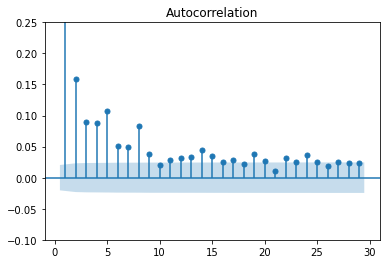

In [8]:
# fetch data through yahoo finance API, compute features, split into training and validation subsets
# ... for both NN and HAR

data = get_rv_from_yahoo("KO")

data_nn_train, data_nn_val, data_har_train, data_har_val = pre_process_all_data(data, train_size=.6)

# to determine gap used in TimeSeriesSplit
plot_acf(data_har_train.y, lags = range(1, 30))
plt.ylim(-0.1, 0.25)
plt.show()

### Model Specification of the Neural Network
Perform cross validation on a feed-forward neural network, with varying hidden layers, nodes, learning rate and epochs.
The NN is estimated using Adam optimzer and MSE loss, with a specified learning rate.

In [10]:
# PERFORM CROSS VALIDATION
model_scores = []

hidden_layers_list = ([],)
lr_list = (1e-3, 5e-3)
epochs_list = (5, 10, 25)
total_model_options = len(hidden_layers_list) * len(lr_list) * len(epochs_list)

# for all possible models, perform kfold cross validation
counter = 0
for hidden_layers in hidden_layers_list:
    for lr in lr_list:
        for epochs in epochs_list:
            counter += 1
            print(f"Currently at model: {counter} / {total_model_options}", end="\r")
            
            avg_score_multiple_folds_list = [           
                # fit and evaluate model through cross validation
                kfolds_fit_and_evaluate_model(
                    input_size = data_nn_train.x_t.shape[1],
                    output_size = 1,
                    hidden_layers = hidden_layers,
                    # kfold = TimeSeriesSplit(n_splits = 10, max_train_size = None, test_size = 500, gap = 25), # the test_size = len(data) // (n_splits + 1)
                    kfold = TimeSeriesSplit(n_splits = 10, max_train_size = None, test_size = 500, gap = 25), # the test_size = len(data) // (n_splits + 1)
                    data = data_nn_train,
                    lr = lr, 
                    epochs = epochs, 
                    earlystopper = None,#EarlyStopper(patience=3, min_delta=0),
                    normalize_features = False
                )
                for i in range(10)
            ]
                
            avg_score_multiple_folds = np.average(avg_score_multiple_folds_list)
            
            print(f"model: hidden layers={hidden_layers} lr={lr} epochs={epochs}")
            print(f"avg score: {avg_score_multiple_folds} list of scores: {avg_score_multiple_folds_list}")
            
            # store the models performance in array
            model_scores += [(avg_score_multiple_folds, epochs, hidden_layers, lr)]
            # model_scores += [(score_nn, epochs, hidden_layers, lr)]

# put all scores with hyperparams in a dataframe, sort on lowest MSE and show
df_scores = pd.DataFrame(data = model_scores, columns = ["avg_score", "epochs", "hidden_nodes", "lr"])
df_scores = df_scores.sort_values(by="avg_score", ascending = True).reset_index(drop=True)
print(df_scores.head(10))

# store best params as variables for the final estimation beneath
epochs, hidden_layers, lr = df_scores.values[0][1:]
epochs = int(epochs)

model: hidden layers-[] lr-0.001 epochs-10
avg score: 2.381182080329136e-06 list of scores: [1.6225700837040334e-06, 1.5961696981179329e-06, 1.8449698020965853e-06, 5.333135756071528e-06, 1.765647244251767e-06, 3.2951697898724327e-06, 2.351877381844503e-06, 2.671555386417168e-06, 1.7139245917894287e-06, 1.616801069125984e-06]
model: hidden layers-[] lr-0.005 epochs-10
avg score: 1.8085399089343034e-06 list of scores: [1.979982700335725e-06, 1.8638982135765754e-06, 1.7710791259952784e-06, 1.7338576360961258e-06, 1.8867676790375041e-06, 1.8435601136097547e-06, 1.6856618224654336e-06, 1.6334870950096557e-06, 1.8328496531552218e-06, 1.8542550500617597e-06]
model: hidden layers-[] lr-0.01 epochs-10
avg score: 2.093414936152449e-06 list of scores: [1.8113792265026513e-06, 1.9068732906770688e-06, 3.0663064659179896e-06, 1.7650575377956558e-06, 2.33342938575376e-06, 1.850696210272673e-06, 2.1880432765986057e-06, 2.149285439619675e-06, 1.9172143217218718e-06, 1.9458642066645383e-06]
model: hidd

### Fit and Compare the Final Neural Network Against the HAR Model

No params from cross validation, using own params instead
Or specifically specified to use own params
HAR out-of-sample loss: 4.4698645965903025e-07


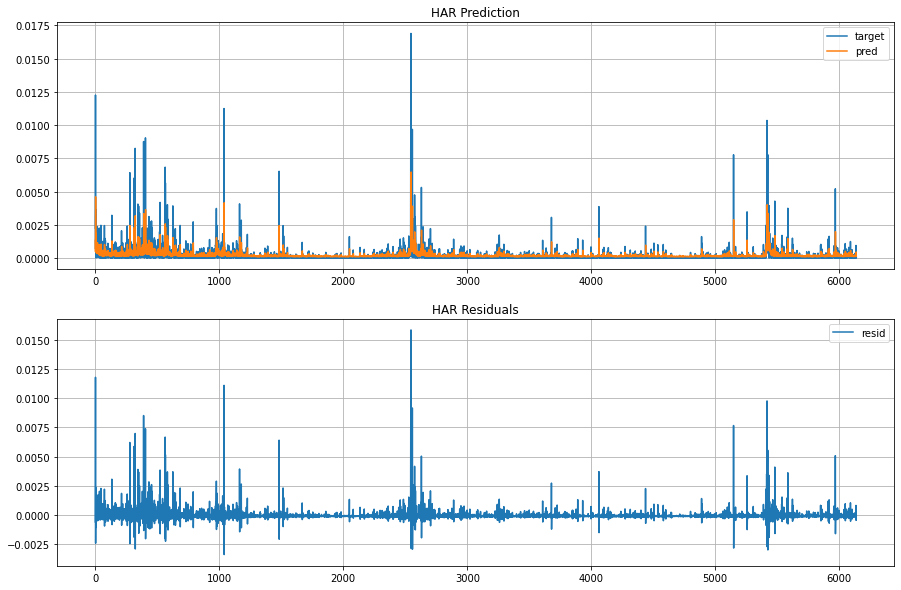

Estimating NN model ...
NN out-of-sample loss: 3.504173378132691e-07


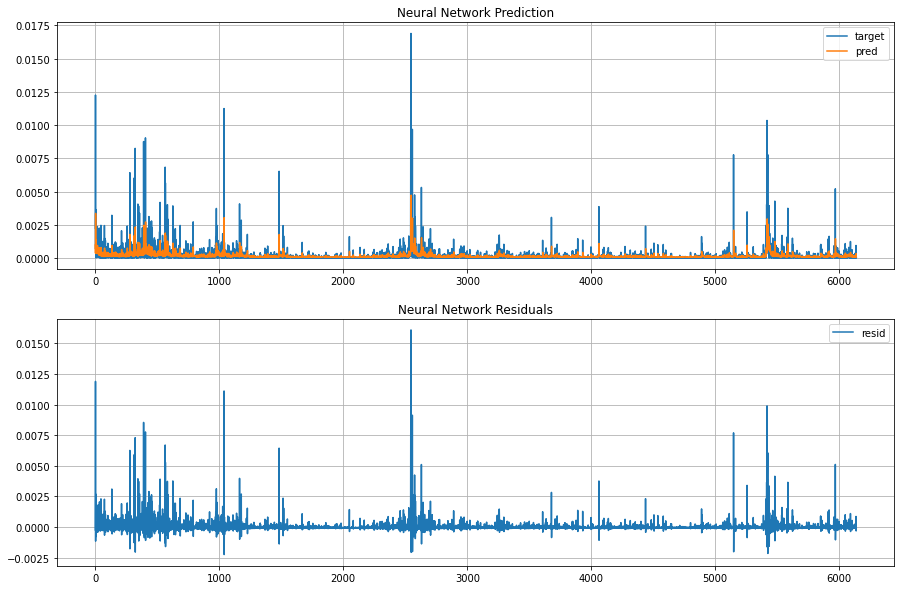

In [67]:
normalize_features = False
use_own_config = True # if you used this once after the cross validation, the custom params 'overwrite' those from cross validation

# sometimes we want to zoom in on specific intervals of the forecast
idx_start, idx_end = 0, 100000

# if the params are not set through cross validations above
try:
    epochs, lr, hidden_layers
    if use_own_config: raise Exception()
except:
    print("No params from cross validation, using own params instead")
    print("Or specifically specified to use own params")
    epochs = 10
    hidden_layers = [] # zero or one with 2 nodes
    lr = .005

#=========================================================================================
#===================================ESTIMATE HAR==========================================
#=========================================================================================
HAR = OLS(np.zeros(10), np.zeros(10)) # these params are placeholders
loss, output = fit_and_evaluateHAR(
    model = HAR,
    data_train = data_har_train,
    data_test = data_har_val,
    normalize_features = False
)
har_output = output.copy()

print(f"HAR out-of-sample loss: {loss}")

plot = True
if plot:        
    # plot prediction versus true daily volatility
    fig, axs = plt.subplots(2,1, figsize = (15, 10))
    axs[0].set_title("HAR Prediction")
    axs[1].set_title("HAR Residuals")
    axs[0].plot(data_har_val.y[idx_start:idx_end], label = "target")
    axs[0].plot(output[idx_start:idx_end], label = "pred")
    axs[1].plot((data_har_val.y.reshape(-1,) - output)[idx_start:idx_end], label = "resid")
     
    for ax in axs:
        ax.legend()
        ax.grid()
    plt.show()

#=========================================================================================
#====================================ESTIMATE NN==========================================
#=========================================================================================
print("Estimating NN model ...")

NN = ForwardNeuralNetwork(
    data_nn_train.x_t.shape[1], 
    output_size = 1, 
    hidden_layers=hidden_layers, 
    # seed=3407
    )
loss, output = single_fit_and_evaluate_model(
    NN,
    data_train = data_nn_train,
    data_test = data_nn_val,
    lr = lr,
    epochs = epochs,
    earlystopper = None,
    normalize_features = False,
    return_prediction = True
)
nn_output =  output.detach().numpy().reshape(-1,).copy()

print(f"NN out-of-sample loss: {loss}")

plot = True
if plot:
    # plot prediction versus true daily volatility
    fig, axs = plt.subplots(2,1, figsize = (15,10))
    axs[0].set_title("Neural Network Prediction")
    axs[1].set_title("Neural Network Residuals")
    axs[0].plot(data_nn_val.y_t.detach().numpy().reshape(-1,1)[idx_start:idx_end], label = "target")
    axs[0].plot(output.detach().numpy()[idx_start:idx_end], label = "pred")
    axs[1].plot((data_nn_val.y_t.detach().numpy().reshape(-1,1) - output.detach().numpy())[idx_start:idx_end], label = "resid")
    
    for ax in axs:
        ax.legend()
        ax.grid()
    plt.show()

In [68]:
#=========================================================================================
#====================================DIEBOLD-MARIANO======================================
#=========================================================================================
dm_test(
    data_har_val.y.reshape(-1,), 
    nn_output,
    har_output, 
    one_sided=True,
    )
# if one sided, only test if the upper forecast performs significantly better than the lower forecast

(-2.0463503671430128, 0.0203822120359299)

In [19]:
for name, param in NN.named_parameters():
    if param.requires_grad:
        print(name, param.data[0])

layers.0.weight tensor([ 0.4430,  0.3777, -0.3068])
layers.0.bias tensor(0.0962)
layers.2.weight tensor([ 0.3049, -0.2997])
layers.2.bias tensor(-0.0059)


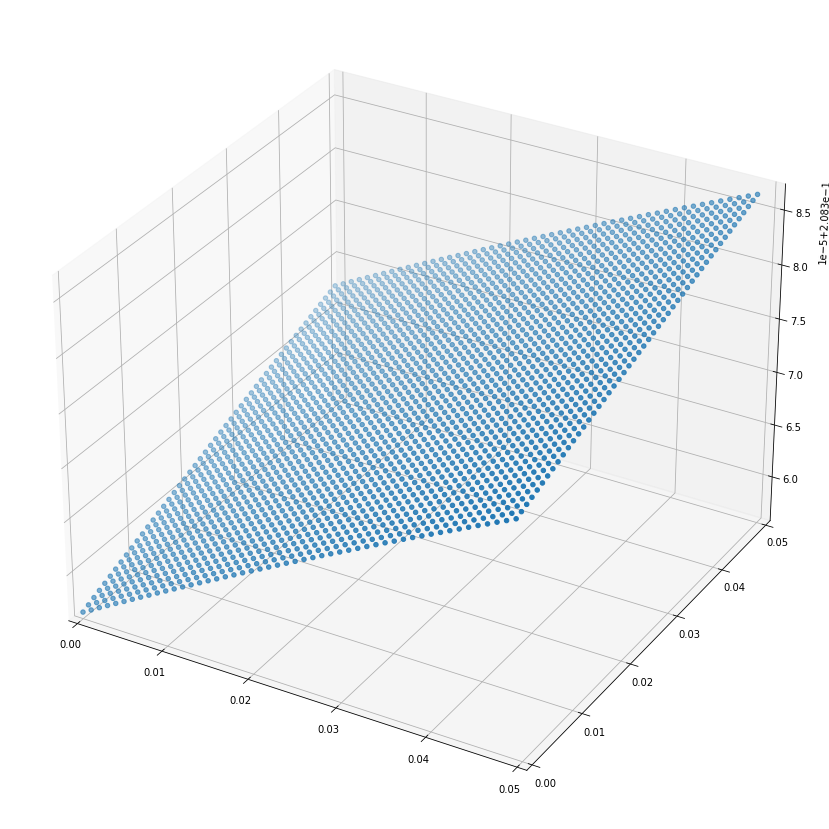

In [21]:

X = np.arange(0, 0.05, .001)
Y = np.arange(0, 0.05, .001)

features = np.zeros((len(X)*len(Y), 3))
i = 0
for Xi in X:
    for Yi in Y:
        features[i] = (0, Xi, Yi)
        i += 1
X = torch.tensor(features, dtype=torch.float32)

Y = NN(X).detach().numpy().reshape(-1,)
X = X.detach().numpy()
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')

X, Y, Z = X[:,1], X[:, 2], Y
ax.scatter(X, Y, Z)
ax.set_xlim(0, 0.05)
ax.set_ylim(0, 0.05)
ax.set_zlim(min(Z), max(Z))
plt.show()


In [9]:
kfold = TimeSeriesSplit(n_splits = 10, max_train_size = None, test_size=500, gap=25)
for idx_train, idx_test in kfold.split(data_nn_train.x_t):
    train_start, train_end = idx_train[0], idx_train[-1]
    test_start, test_end = idx_test[0], idx_test[-1]
    print(train_start, train_end, "-", test_start, test_end)


ValueError: Too many splits=10 for number of samples=1195 with test_size=500 and gap=25.

Estimating NN model ...
NN out-of-sample loss: 0.025191152468323708


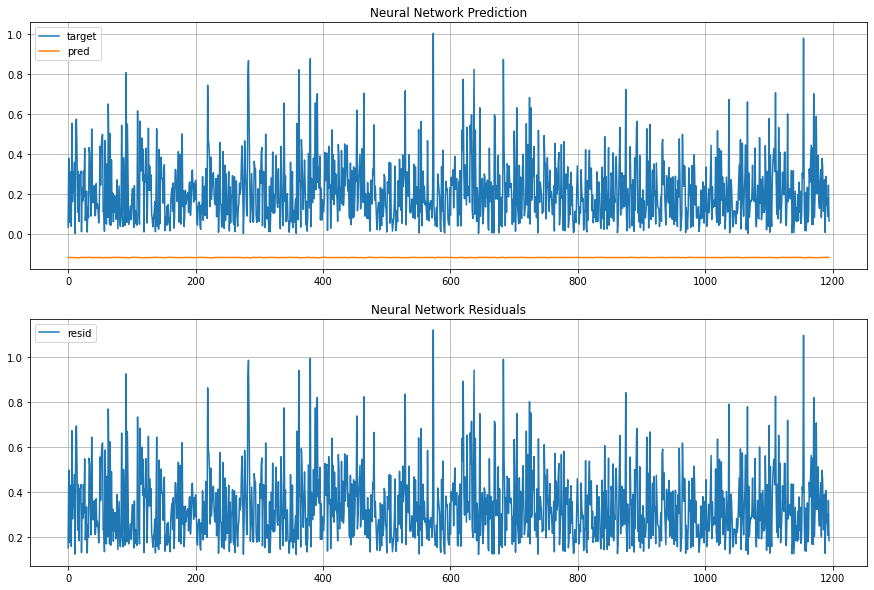

In [15]:
plot = True # plot for both models the true volatility versus the predicted one

idx_start, idx_end = 0, 100000
#=========================================================================================
#====================================IN-SAMPLE NN=========================================
#=========================================================================================
print("Estimating NN model ...")

NN = ForwardNeuralNetwork(data_nn_train.x_t.shape[1], output_size = 1, hidden_layers=hidden_layers, seed=3407)
NN_in_sample_output = NN(data_nn_train.x_t)
nn_in_sample_output =  NN_in_sample_output.detach().numpy().reshape(-1,)

print(f"NN out-of-sample loss: {loss}")

plot = True
if plot:
    # plot prediction versus true daily volatility
    fig, axs = plt.subplots(2,1, figsize = (15,10))
    axs[0].set_title("Neural Network Prediction")
    axs[1].set_title("Neural Network Residuals")
    axs[0].plot(data_nn_train.y_t.detach().numpy().reshape(-1,)[idx_start:idx_end], label = "target")
    axs[0].plot(nn_in_sample_output[idx_start:idx_end], label = "pred")
    axs[1].plot((data_nn_train.y_t.detach().numpy().reshape(-1,) - nn_in_sample_output)[idx_start:idx_end], label = "resid")
    
    for ax in axs:
        ax.legend()
        ax.grid()
    plt.show()